In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
from scipy import ndimage
import cmath
import math
import Image
from keras.datasets import mnist
from keras.datasets import cifar10
from collections import Counter


def resize(input_im):
    im = Image.fromarray(input_im)
    im = im.resize([10,10], Image.ANTIALIAS)
    rz_im = np.asarray((im.getdata()))
    return np.reshape(rz_im, (10,10))

def getXsvd(imgmat,k):
    U, sigma, V = np.linalg.svd(imgmat)
    reconstimg = np.matrix(U[:, :k]) * np.diag(sigma[:k]) * np.matrix(V[:k, :])
    return reconstimg
    
def getX_10():    
    X_10_train = np.zeros((60000,10,10))
    X_10_test =  np.zeros((10000,10,10))
    (X_train, _), (X_test, _) = mnist.load_data()
    for i in range(X_train.shape[0]):
        X_10_train[i,:,:] = resize(X_train[i])
    for i in range(X_test.shape[0]):
        X_10_test[i,:,:] = resize(X_test[i])
    return X_10_train,X_10_test

def get_mode_by_order(w):
    data = Counter(w.flatten())
    mode_w = data.most_common(len(data))  # Returns the highest occurring item
    
    dic = {}

    for num in mode_w:
        for j in [10,100,1000,10000,100000,1000000,10000000,100000000,1000000000,
                  10000000000,100000000000,1000000000000,10000000000000,100000000000000,
                  1000000000000000,10000000000000000,100000000000000000,1000000000000000000,
                  10000000000000000000L,100000000000000000000L,1000000000000000000000L,
                  10000000000000000000000L,100000000000000000000000L,1000000000000000000000000L,
                  10000000000000000000000000L,100000000000000000000000000L,1000000000000000000000000000L,
                  10000000000000000000000000000L,100000000000000000000000000000L]:
            res = abs(num[0] * j)
            if res >= 1 and res < 10:
                dic[j] = dic.get(j,0)+1
    
#     return dic.iteritems()    
    return sorted([(1./k,v) for (k,v) in dic.iteritems()],key=lambda tup:tup[1],reverse=True)

def get_lw(l_wrt_w):
    loss = np.zeros((512,10))
    weights = np.zeros((512,10))

    for i in range(512):
        for j in range(10):
            loss[i,j] = l_wrt_w[i,j,0]
            weights[i,j] = l_wrt_w[i,j,1]    
    return loss,weights

Using Theano backend.


# Playing with last layer (only Dense10)

In [22]:
from __future__ import print_function
import numpy as np
import random
np.random.seed(1337)  # for reproducibility

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.regularizers import l2, activity_l2

batch_size = 32
nb_classes = 10
nb_epoch = 100
data_augmentation = True

# input image dimensions
img_rows, img_cols = 32, 32
# the CIFAR10 images are RGB
img_channels = 3

nb_slice = 5000


# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train.reshape(50000, 3072)
X_test = X_test.reshape(10000, 3072)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train[:nb_slice], nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)
for reg in [1e-01,1e-02,1e-03,1e-04,1e-05,1e-06,1e-07,1e-08,1e-09,1e-10,555]:
    
    print("Training on reg = ", reg)

    FC0 = Dense(1024, input_shape=(img_channels*img_rows*img_cols,))
    FC1 = Dense(512)
    if reg != 555:
        FC2 = Dense(10, W_regularizer=l2(reg))
    else:
        FC2 = Dense(10)
    # FC2 = Dense(10) #test wij 1e-6 1e-5 20 1e-1 1e-2 1e-20

    model = Sequential()
    model.add(FC0)
    model.add(Activation('relu'))
    model.add(FC1)
    model.add(Activation('relu'))
    model.add(FC2)
    # model.add(Activation('softmax'))

#     model.summary()

    model.compile(loss='mse',
                  optimizer='adadelta',
                  metrics=['accuracy'])

    history = model.fit(X_train[:nb_slice], Y_train[:nb_slice],
                        batch_size=batch_size, nb_epoch=nb_epoch,
                        verbose=1, validation_data=(X_test, Y_test), shuffle=True)

    score = model.evaluate(X_test, Y_test, verbose=1)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    test_score = score[0]

X_train shape: (50000, 3072)
50000 train samples
10000 test samples
Training on reg =  0.1
Train on 5000 samples, validate on 10000 samples
Epoch 1/60
5000/5000 [==============================] - 11s - loss: 0.1295 - acc: 0.1804 - val_loss: 0.1209 - val_acc: 0.2169
Epoch 2/60
5000/5000 [==============================] - 11s - loss: 0.0887 - acc: 0.2452 - val_loss: 0.0959 - val_acc: 0.1633
Epoch 3/60
5000/5000 [==============================] - 11s - loss: 0.0846 - acc: 0.2848 - val_loss: 0.0862 - val_acc: 0.2694
Epoch 4/60
5000/5000 [==============================] - 11s - loss: 0.0816 - acc: 0.3276 - val_loss: 0.0870 - val_acc: 0.2861
Epoch 5/60
5000/5000 [==============================] - 11s - loss: 0.0794 - acc: 0.3568 - val_loss: 0.1005 - val_acc: 0.2002
Epoch 6/60
5000/5000 [==============================] - 11s - loss: 0.0775 - acc: 0.3766 - val_loss: 0.0915 - val_acc: 0.2858
Epoch 7/60
5000/5000 [==============================] - 11s - loss: 0.0759 - acc: 0.3992 - val_loss: 0.0

# Original accuracy without regularizer
Epoch 60/60
5000/5000 [==============================] - 27s - loss: 0.0196 - acc: 0.9502 - val_loss: 0.0950 - val_acc: 0.3707  
Test score: 0.0949578118324
Test accuracy: 0.3707


In [10]:
layer4_weights = np.copy(model.layers[4].get_weights())

l4_alt_10 = np.copy(layer4_weights)
l_wrt_w_10 = np.zeros(layer4_weights[0].shape + (2,))

l4_alt_100 = np.copy(layer4_weights)
l_wrt_w_100 = np.zeros(layer4_weights[0].shape + (2,))

l4_alt_200 = np.copy(layer4_weights)
l_wrt_w_200 = np.zeros(layer4_weights[0].shape + (2,))

In [11]:
print(l_wrt_w_10.shape)
print(l_wrt_w_100.shape)
print(l_wrt_w_200.shape)

(512, 10, 2)
(512, 10, 2)
(512, 10, 2)


In [12]:
# Change the weight only 1 at the time
# evaluate the loss thru the network
# - calculate diff of 
#   - 1) Test Score 
#   - 2) Weight difference (From the original and the altered one[/10 and /100])
# set the weight back 

for idx in [0,2,4]:
    model.layers[idx].trainable = False

for i in range(l_wrt_w_10.shape[0]):
    for j in range(l_wrt_w_10.shape[1]):
        '''
         save the weight dummy
         alter the value of the weight by 10,100,200
         set the weight back to the network and compute the loss
         save the score differences and the weight differences into the l_wrt_w matrix
         set the weight that we altered back with the dummy
         
         IMP: Need to do for each weight because Python has something weird in its
         Matrix references, considered read more Python book, but this works anyway
        '''
#         w_dummy = layer4_weights[0][i][j]
#         l4_alt_10[0][i][j] /= 10
#         model.layers[4].set_weights(l4_alt_10)
#         score_10 = model.evaluate(X_test_10000, Y_test, verbose=0)
#         l_wrt_w_10[i][j][0] = test_score - score_10[0]
#         l_wrt_w_10[i][j][1] = w_dummy - l4_alt_10[0][i][j]
#         l4_alt_10[0][i][j] = w_dummy
        
#         w_dummy = layer4_weights[0][i][j]
#         l4_alt_100[0][i][j] /= 100
#         model.layers[4].set_weights(l4_alt_100)
#         score_100 = model.evaluate(X_test, Y_test, verbose=0)
#         l_wrt_w_100[i][j][0] = test_score - score_100[0]
#         l_wrt_w_100[i][j][1] = w_dummy - l4_alt_100[0][i][j]
#         l4_alt_100[0][i][j] = w_dummy

        w_dummy = layer4_weights[0][i][j]
        l4_alt_200[0][i][j] /= 200
        model.layers[4].set_weights(l4_alt_200)
        score_200 = model.evaluate(X_test, Y_test, verbose=0)
        l_wrt_w_200[i][j][0] = test_score - score_200[0]
        l_wrt_w_200[i][j][1] = w_dummy - l4_alt_200[0][i][j]        
        l4_alt_200[0][i][j] = w_dummy
        
        if (j%5 == 0 and i%5 == 0):
            print("i,j,l_wrt_w_10,l_wrt_w_100,l_wrt_w_200 = ", i, j,
                 l_wrt_w_10[i][j][1],
                 l_wrt_w_100[i][j][1],
                 l_wrt_w_200[i][j][1])

i,j,l_wrt_w_10,l_wrt_w_100,l_wrt_w_200 =  0 0 0.0 0.0 0.0381034836173
i,j,l_wrt_w_10,l_wrt_w_100,l_wrt_w_200 =  0 5 0.0 0.0 0.0687614828348
i,j,l_wrt_w_10,l_wrt_w_100,l_wrt_w_200 =  5 0 0.0 0.0 -0.0846467539668
i,j,l_wrt_w_10,l_wrt_w_100,l_wrt_w_200 =  5 5 0.0 0.0 0.104270577431
i,j,l_wrt_w_10,l_wrt_w_100,l_wrt_w_200 =  10 0 0.0 0.0 -0.000289582443656
i,j,l_wrt_w_10,l_wrt_w_100,l_wrt_w_200 =  10 5 0.0 0.0 -0.0833028331399
i,j,l_wrt_w_10,l_wrt_w_100,l_wrt_w_200 =  15 0 0.0 0.0 -0.0625335350633
i,j,l_wrt_w_10,l_wrt_w_100,l_wrt_w_200 =  15 5 0.0 0.0 -0.0230768229812
i,j,l_wrt_w_10,l_wrt_w_100,l_wrt_w_200 =  20 0 0.0 0.0 -0.101117536426
i,j,l_wrt_w_10,l_wrt_w_100,l_wrt_w_200 =  20 5 0.0 0.0 0.0335997752845
i,j,l_wrt_w_10,l_wrt_w_100,l_wrt_w_200 =  25 0 0.0 0.0 -0.0519656427205
i,j,l_wrt_w_10,l_wrt_w_100,l_wrt_w_200 =  25 5 0.0 0.0 0.0245690401644
i,j,l_wrt_w_10,l_wrt_w_100,l_wrt_w_200 =  30 0 0.0 0.0 -0.106336459517
i,j,l_wrt_w_10,l_wrt_w_100,l_wrt_w_200 =  30 5 0.0 0.0 0.0171834342182
i,j

# Save the l_wrt_w in file

In [13]:
import pickle


with open('l_wrt_w_100_cifar10_hv', 'wb') as handle:
    pickle.dump(l_wrt_w_100, handle)
    
with open('l_wrt_w_200_cifar10_hv', 'wb') as handle:
    pickle.dump(l_wrt_w_200, handle)

# with open('l_wrt_w_10_foverfit', 'wb') as handle:
#     pickle.dump(l_wrt_w_10, handle)
    
# with open('l_wrt_w_100_foverfit', 'wb') as handle:
#     pickle.dump(l_wrt_w_100, handle)
    
# with open('l_wrt_w_200_foverfit', 'wb') as handle:
#     pickle.dump(l_wrt_w_200, handle)

# with open('l_wrt_w_10_nsm', 'wb') as handle:
#     pickle.dump(l_wrt_w_10, handle)
    
# with open('l_wrt_w_100_nsm', 'wb') as handle:
#     pickle.dump(l_wrt_w_100, handle)
    
# with open('l_wrt_w_200_nsm', 'wb') as handle:
#     pickle.dump(l_wrt_w_200, handle)

# with open('model_l0_weight', 'wb') as handle:
#     pickle.dump(model.layers[0].get_weights(), handle)

# with open('model_l2_weight', 'wb') as handle:
#     pickle.dump(model.layers[2].get_weights(), handle)

# with open('model_l4_weight', 'wb') as handle:
#     pickle.dump(model.layers[4].get_weights(), handle)
    
# pf = open('l_wrt_w_lastlayer_9888','rb')
# l_wrt_w = pickle.load(pf)

In [14]:
l_diff_10, w_diff_10 = get_lw(l_wrt_w_10)
l_diff_100, w_diff_100 = get_lw(l_wrt_w_100)
l_diff_200, w_diff_200 = get_lw(l_wrt_w_200)
dl_dw_10 = l_diff_10/w_diff_10
dl_dw_100 = l_diff_100/w_diff_100
dl_dw_200 = l_diff_200/w_diff_200

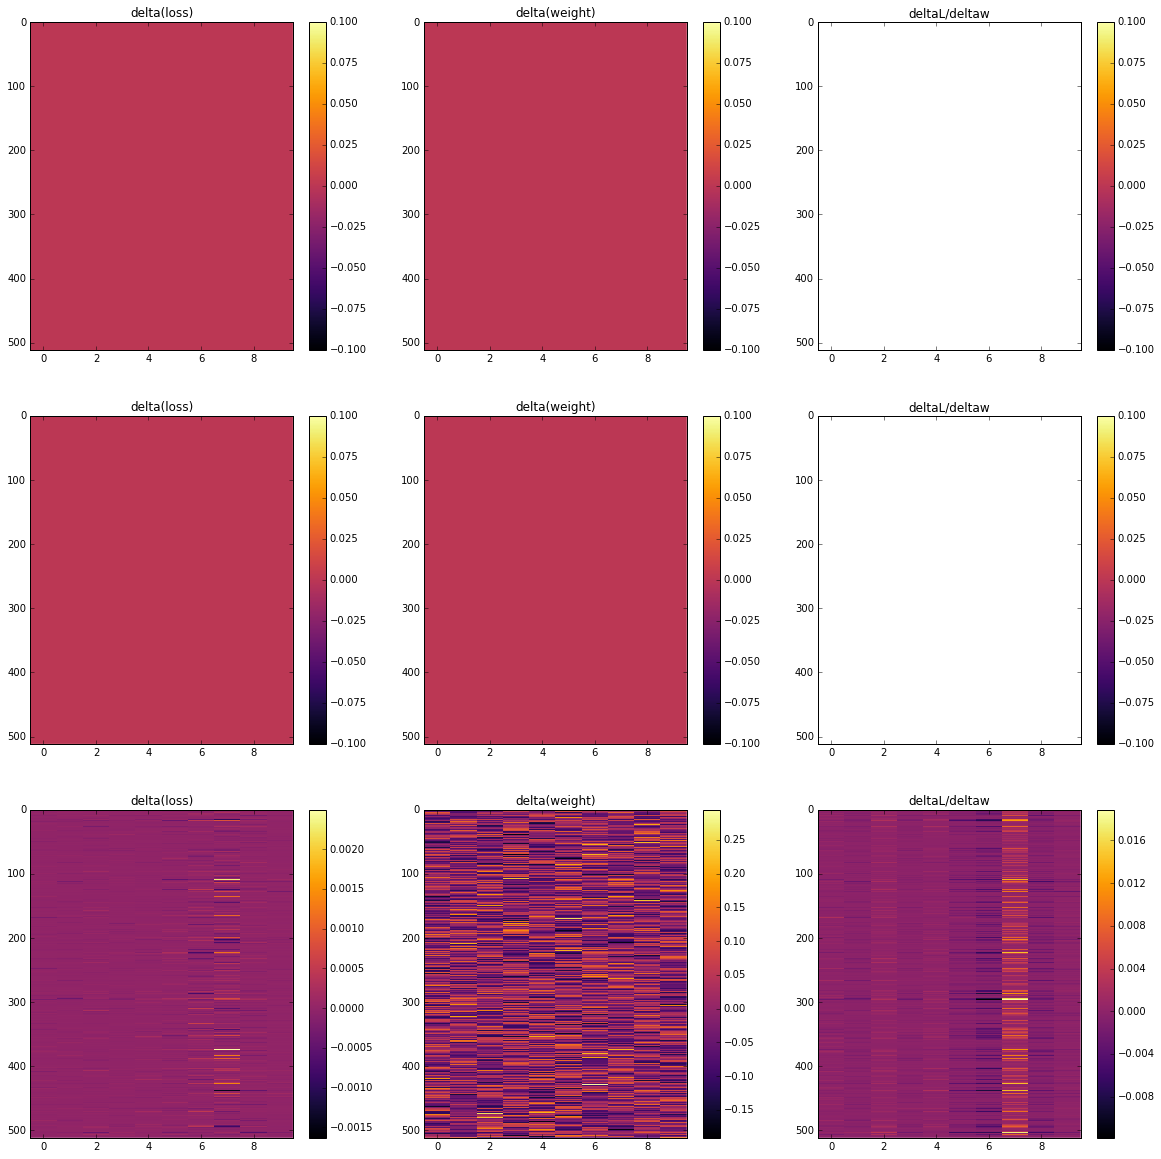

In [15]:
plt.figure(figsize=(20,20))
plt.subplot(331)
plt.imshow(l_diff_10, cmap='inferno', aspect='auto', interpolation='none')
plt.title('delta(loss)')
plt.colorbar()

plt.subplot(332)
plt.imshow(w_diff_10, cmap='inferno', aspect='auto', interpolation='none')
plt.title('delta(weight)')
plt.colorbar()

plt.subplot(333)
plt.imshow(dl_dw_10, cmap='inferno', aspect='auto', interpolation='none')
plt.title('deltaL/deltaw')
plt.colorbar()

plt.subplot(334)
plt.imshow(l_diff_100, cmap='inferno', aspect='auto', interpolation='none')
plt.title('delta(loss)')
plt.colorbar()

plt.subplot(335)
plt.imshow(w_diff_100, cmap='inferno', aspect='auto', interpolation='none')
plt.title('delta(weight)')
plt.colorbar()

plt.subplot(336)
plt.imshow(dl_dw_100, cmap='inferno', aspect='auto', interpolation='none')
plt.title('deltaL/deltaw')
plt.colorbar()

plt.subplot(337)
plt.imshow(l_diff_200, cmap='inferno', aspect='auto', interpolation='none')
plt.title('delta(loss)')
plt.colorbar()

plt.subplot(338)
plt.imshow(w_diff_200, cmap='inferno', aspect='auto', interpolation='none')
plt.title('delta(weight)')
plt.colorbar()

plt.subplot(339)
plt.imshow(dl_dw_200, cmap='inferno', aspect='auto', interpolation='none')
plt.title('deltaL/deltaw')
plt.colorbar()

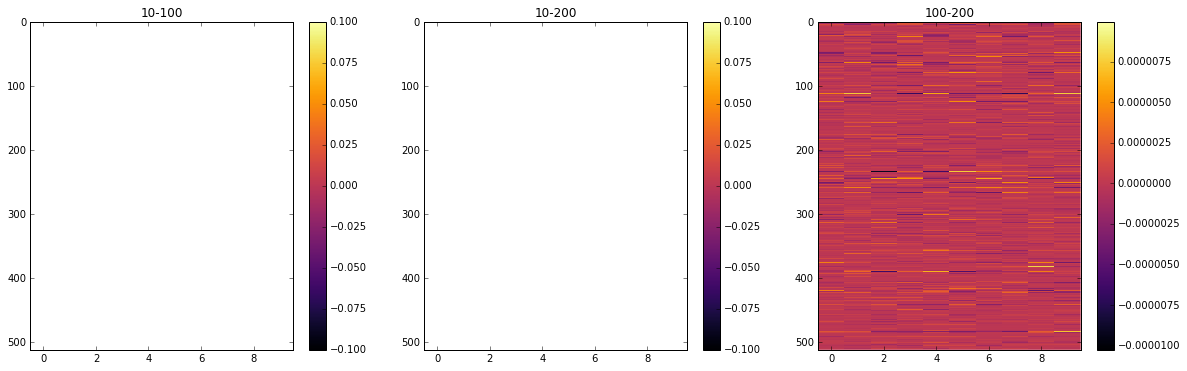

In [10]:
plt.figure(figsize=(20,20))
plt.subplot(331)
plt.imshow(dl_dw_10 - dl_dw_100, cmap='inferno', aspect='auto', interpolation='none')
plt.title('10-100')
plt.colorbar()

plt.subplot(332)
plt.imshow(dl_dw_10 - dl_dw_200, cmap='inferno', aspect='auto', interpolation='none')
plt.title('10-200')
plt.colorbar()

plt.subplot(333)
plt.imshow(dl_dw_100 - dl_dw_200, cmap='inferno', aspect='auto', interpolation='none')
plt.title('100-200')
plt.colorbar()

# Print the mainstream order of weight

# Compute the lambda 
$$ -2\lambda w_{ij} = \frac{\partial L}{\partial w_{ij}} $$
$$ \lambda = \frac{\partial L}{\partial w_{ij}} \times \left(\frac{-1}{2w_{ij}}\right) $$

In [16]:
lamb_10 = dl_dw_10 * (-1/2*(layer4_weights[0]))
lamb_100 = dl_dw_100 * (-1/2*(layer4_weights[0]))
lamb_200 = dl_dw_200 * (-1/2*(layer4_weights[0]))

In [20]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(20,40))
# a = np.hstack(lamb_200)
# plt.hist(a, bins=300)  # plt.hist passes it's arguments to np.histogram
# plt.plot(bins, y, 'r--', linewidth=1)
# plt.title("Histogram of the value we got from long equation")
# plt.show()

In [17]:
print("dl_dw10=", get_mode_by_order(dl_dw_10))
print("dl_dw100=", get_mode_by_order(dl_dw_100))
print("dl_dw200=", get_mode_by_order(dl_dw_200))

print("lamb10=", get_mode_by_order(lamb_10))
print("lamb100=", get_mode_by_order(lamb_100))
print("lamb200=", get_mode_by_order(lamb_200))

dl_dw10= []
dl_dw100= []
dl_dw200= [(0.0001, 2589), (1e-05, 1350), (0.001, 848), (1e-06, 261), (1e-07, 46), (0.01, 19), (1e-08, 7)]
lamb10= []
lamb100= []
lamb200= [(1e-05, 2067), (1e-06, 1798), (1e-07, 619), (0.0001, 450), (1e-08, 149), (1e-09, 20), (0.001, 14), (1e-10, 3)]


In [22]:
print("Bigdelta of 100,200", get_mode_by_order(dl_dw_100-dl_dw_200))

Bigdelta of 100,200 [(1e-07, 2766), (1e-08, 1276), (1e-06, 833), (1e-09, 212), (1e-10, 26), (1e-11, 3), (1e-12, 2), (1e-05, 1)]


# How much the weight is incremented for each epoch?
 - run another epoch, get the mode of weight difference
 - got the most popular at 1e-05

# Finding the nb of order that most used to represent keras's weight

In [ ]:
# get_mode_by_order(layer4_weights[0])

# Test the equation we derive and check the order of lambda

In [13]:
def lag(w,xs,ys):
    Nb_of_samples = xs.shape[0]
    n = w.shape[0]
    d = w.shape[1]
    lamb = np.zeros((n,d))
    for lamb_i in range(n):
        for lamb_j in range(d):
            inner_sum = 0.
            outer_sum = 0.
            big_result = 0.
            for inner_i in range(n):
                for inner_j in range(d):
                    inner_sum += np.dot(xs[inner_i][inner_j],w[inner_i][inner_j]) - ys[inner_i]
                outer_sum += inner_sum
            big_result = outer_sum * (x[lamb_j]/w[lamb_i][lamb_j])
            big_result = (-1/Nb_of_samples) * big_result
            lamb[lamb_i][lamb_j] = big_result
    return np.copy(lamb)
    
    
ex_lamb = lag(layer4_weights[0].T, x_layer4[0],y_train)
get_mode_by_order(ex_lamb)

NameError: name 'x_layer4' is not defined

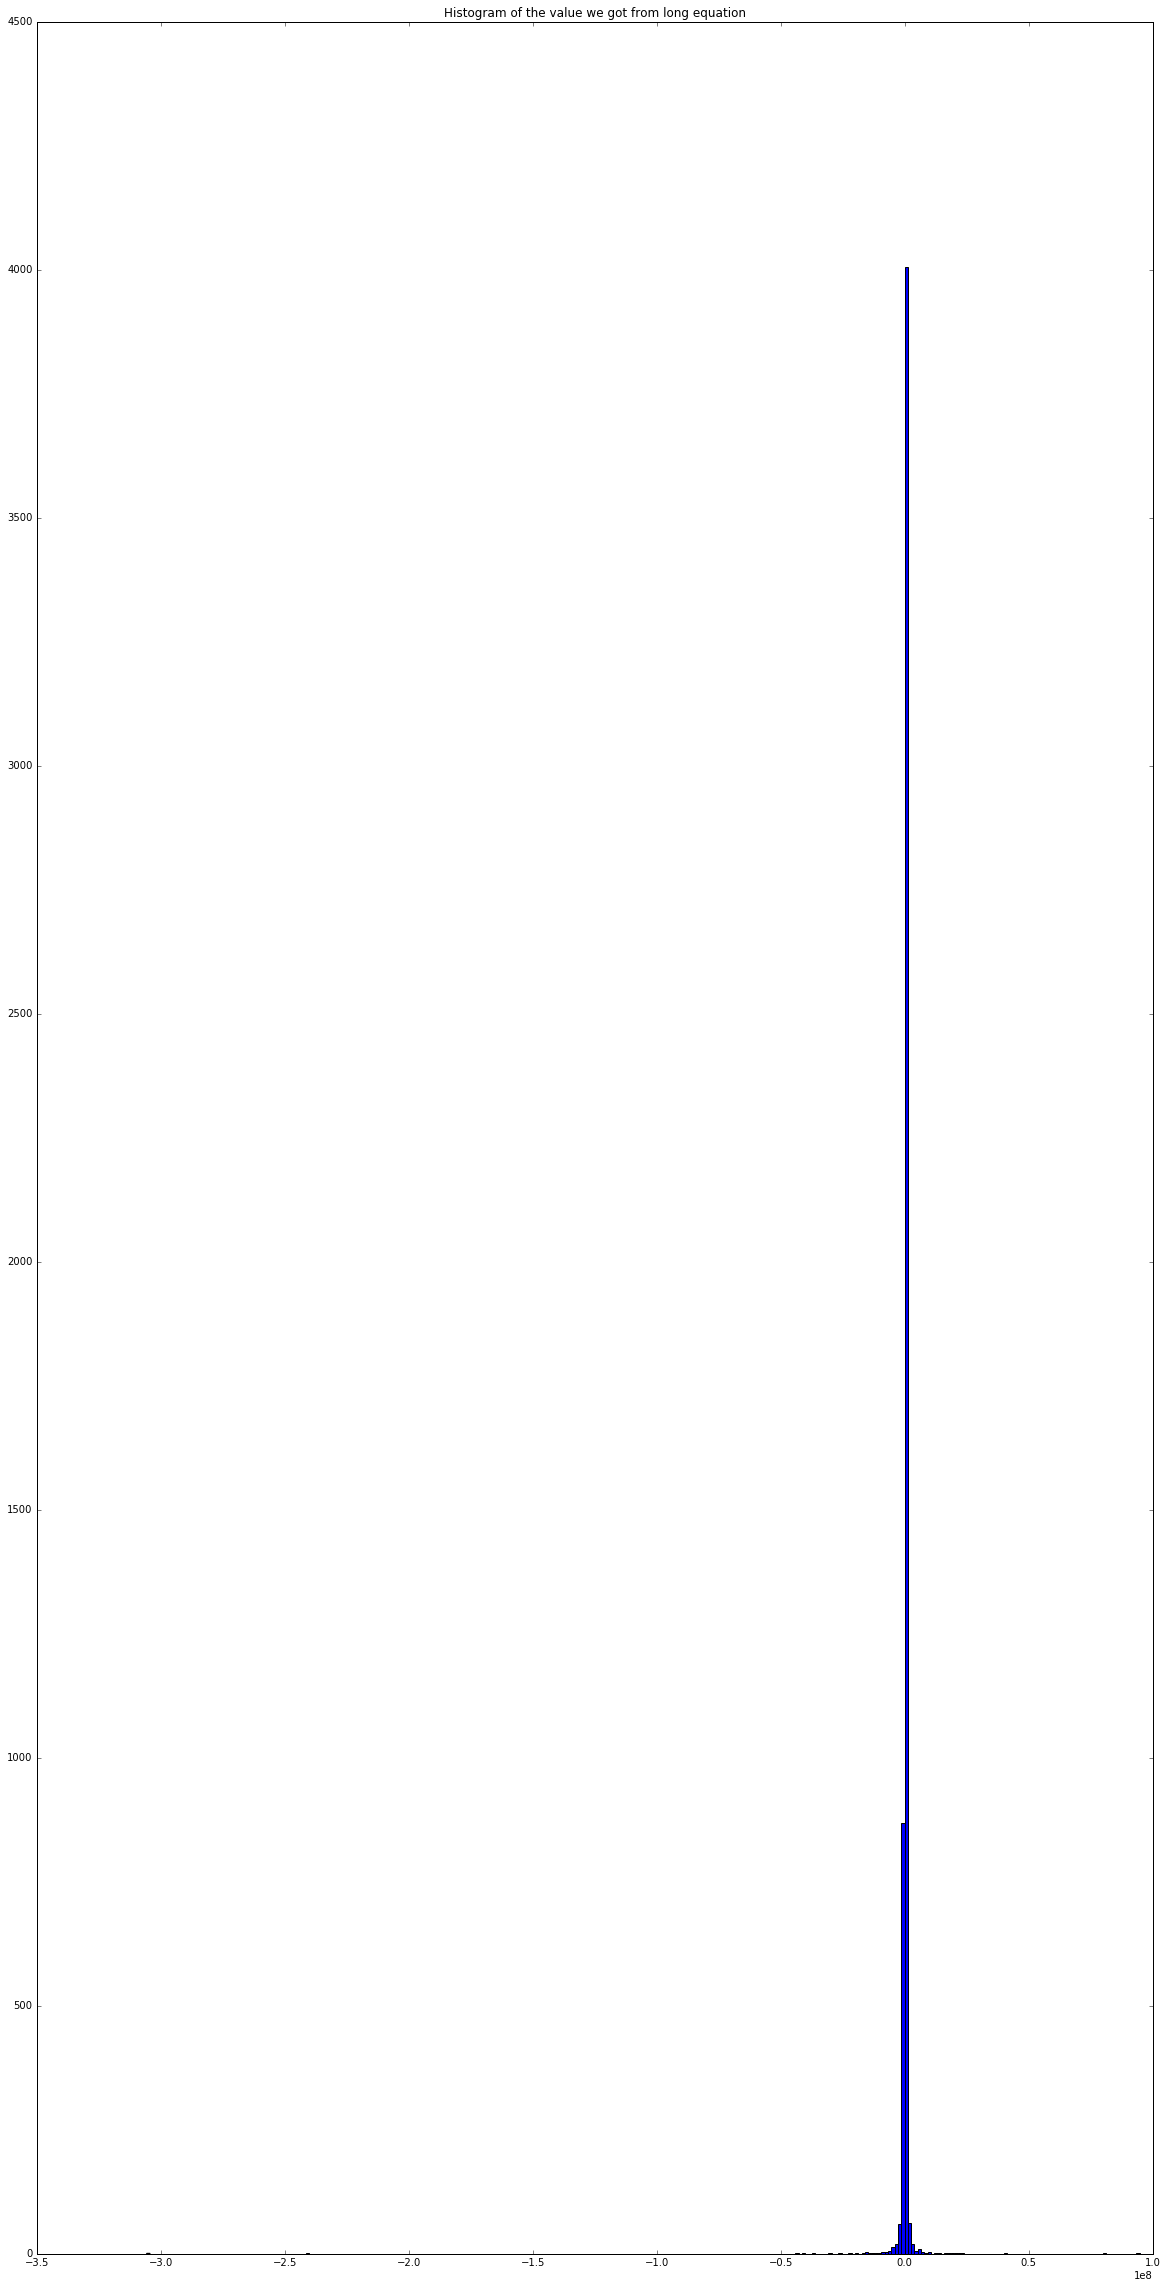

In [236]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,40))
a = np.hstack(ex_lamb.flatten())
plt.hist(a, bins=300)  # plt.hist passes it's arguments to np.histogram
plt.title("Histogram of the value we got from long equation")
plt.show()